<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Проект по теме "CycleGAN"</b></h3>



**Описание:** Идея выполненной работы состояла в том, чтобы научить CycleGAN-модель переводить фотографии дневных изображений в ночные. Поскольку CycleGAN как раз и занимается, по сути, перекрашиванием изображений с не очень значительным изменением геометрии (в статье как раз указано на трудность геометрических преобразований с помощью CycleGAN'а), то ожидалось, что до какой-то степени модель будет справляться с поставленной задачей.<br/>
Датасет для этой задачи был собран самостоятельно, скачиванием изображений с pixabay, unsplash duckduckgo и яндекс-картинок. Для дневных и ночных наборов соответственно, были взять 500 городский фото и 500 фото природных ландшафтов. Собрать датасет было весьма проблематично, так как на большом количестве ночных фото из интернета оказались либо фейерверки, либо просто Луна крупным планом и ничего более, кроме того, на подавляющем количестве ночных фотографий была подсветка, даже на фото с природой - не освещение фотографа, но, например, освещение людей в палаточном лагере, в котором , судя по всему, и был сам фотограф - такие детали явно должны были иметь значение при тренировке модели.<br/>
Тренируя модель, я экспериментировал с дабвлением/убиранием буфера (который используется при тренировке дискриминатора), уменьшение количества "внутренних" слоёв в дискриминаторе, а также попробовал добавить L2-регуляризацию с помощью использования параметра `weight_decay` в оптимизаторе. Weight decay и буфер действительно дали небольшое улчшение - обучение перестало ломаться после 50 эпох и вообще проходило более-менее стабильно.<br/>
Основной трудность как раз являлось собирание хорошего датасета - судя по всему, на эту тему нужен отдельный курс на степике. Также, при обработке изображения в телеграм-боте, оно сначала уменьшается до размеров, которые принимает нейросеть, после чего расширяется назад при помощи стандартных методов интерполяции (в боте использовалась бикубическая), поэтому качество значительно падает при использовании нейросети, натренированной на изображения 128х128, однако остаётся приемлемым при использоваении нейросети, натренированной на 256х256.

In [1]:
import os
import math
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

"Глобальные переменные" вроде путей к картинкам датасета и атомарные гиперпараметры модели

In [2]:
PYTORCH_DATALOADER = 'pytorch_dl'
WHOLE_DATASET_LOADER = 'whole_ds_dl'

In [3]:
DATA_DIR = './dataset_128/'
SAVE_PATH = './'
ORIGINALS_FOLDER = 'day'
TARGETS_FOLDER = 'night'
SAMPLES_FOLDER = 'samples'
TEST_FOLDER = 'test'

In [4]:
BATCH_NORM_USAGE_THRESHOLD = 32

In [5]:
IMAGE_SIZE = 128
BATCH_SIZE = 1

In [6]:
LR = 0.0002

In [7]:
OPTIMIZER_BETA1 = 0.5
OPTIMIZER_BETA2 = 0.999

In [8]:
SAMPLES_SHOWN_PER_ROW = 2

In [9]:
EPOCHS = 100

In [10]:
DISCRIMINATOR_HIDDEN_LAYERS = 3
DISCRIMINATOR_INITIAL_CONV_OUT = 64
GENERATOR_INITIAL_CONV_OUT = 64
GENERATOR_ENCODER_BLOCKS = 2

In [11]:
DISCRIMINATOR_SKIPPED_EPOCHS = []
GENERATOR_SKIPPED_EPOCHS = []

In [12]:
MODEL_SAVE_PERIOD = 25 #

In [13]:
GEN_FWD_FNAME_PREFIX = 'gen_fwd'
GEN_BWD_FNAME_PREFIX = 'gen_bwd'
DISC_ORIG_FNAME_PREFIX = 'disc_orig'
DISC_TRGT_FNAME_PREFIX = 'disc_trgt'

HISTORY_FNAME_PREFIX = 'history'

In [14]:
IS_BUFFER_USED = True
BUFFER_SIZE = 30

===Конец "глобальных переменных" и атомарных гиперпараметров модели===

Функции потерь

In [15]:
similarity_criterion = nn.L1Loss()
binary_classifier_criterion = nn.BCELoss() # nn.MSELoss()

Приведение гиперпараметров модели к набору интуитивно понятных переменных.

In [16]:
image_size = IMAGE_SIZE
batch_size = BATCH_SIZE

In [17]:
dataset_folder = DATA_DIR

In [18]:
originals_folder = os.path.join(DATA_DIR, ORIGINALS_FOLDER)
targets_folder = os.path.join(DATA_DIR, TARGETS_FOLDER)
samples_folder = os.path.join(DATA_DIR, SAMPLES_FOLDER)
test_folder = os.path.join(DATA_DIR, TEST_FOLDER)

In [19]:
use_batchnorm = batch_size >= BATCH_NORM_USAGE_THRESHOLD

In [20]:
disc_hidden_layers = DISCRIMINATOR_HIDDEN_LAYERS

In [21]:
generator_residual_blocks = 6 if image_size < 256 else 9

Лоадеры картинок. `DataLoaderWrapper` - высокоуровневая обёртка, поддерживающие методы, нобходимые даталоадеру, плюс метод `to_device` на случай, если зарузка на GPU не нужна. `WholeDatasetLoader` - самописный лоадер, который загружает сразу весь датасет на GPU для значительного ускорения его обработки - работает, разумеется, только если датасет помещается на GPU целиком.

In [22]:
class WholeDatasetLoader:
    def __init__(self, dataset, batch_size, shuffle):
        self.ds = dataset[0][None, :]
        self.batch_size = batch_size

        for i in range(1, len(dataset)):
            self.ds = torch.cat([self.ds, dataset[i][None, :]])
            
        self.shuffle = shuffle
        self.size = len(dataset)
        
        self.ds = self.ds.to(device)
        
    def __iter__(self):
        self.perm = torch.randperm(len(self.size)) if self.shuffle else torch.tensor(range(0, self.size))
        self.ptr = 0
        return self
        
    def __next__(self):
        if self.ptr < self.size:
            ret = self.ds[self.perm[self.ptr : min(self.size, self.ptr + self.batch_size)]]
            self.ptr += self.batch_size
            return ret
        else:
            raise StopIteration

In [23]:
class DataLoaderWrapper:
    def __init__(self, dl_type, dataset, batch_size, shuffle):
        self.dl_type = dl_type
        
        if dl_type == PYTORCH_DATALOADER:
            self.dl = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        elif dl_type == WHOLE_DATASET_LOADER:
            self.dl = WholeDatasetLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        else:
            print('Dataloader of type ' + dl_type + ' is not implemented')
            raise NotImplementedError
            
    def __iter__(self):
        self.iter = iter(self.dl)
        return self
    
    def __next__(self):
        if self.dl_type == PYTORCH_DATALOADER:
            extracted, _ = next(self.iter)
            return extracted
        elif self.dl_type == WHOLE_DATASET_LOADER:
            return next(self.iter)
        else:
            print('Incomplete implementation of ' + self.dl_type + ' dataloader type')
            raise NotImplementedError
    
    def to_device(self, batch):
        if self.dl_type == PYTORCH_DATALOADER:
            return batch.to(device)
        elif self.dl_type == WHOLE_DATASET_LOADER:
            return batch
        else:
            print('Incomplete implementation of ' + self.dl_type + ' dataloader type')
            raise NotImplementedError

Функции для загрузки датасета

In [24]:
def count_files(folder):
    return len([name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name))])

In [25]:
def get_dataset(dataset_folder, image_size, normalization_stats):
    return ImageFolder(DATA_DIR, transform=tt.Compose([
        tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.ToTensor(),
        tt.Normalize(*normalization_stats)]))

In [26]:
def get_dataloader(dataset, batch_size, dl_type, shuffle):
    
    if use_batchnorm and len(dataset) % batch_size == 1:
        print('Batch norm is going to fail with this batch size, because the last batch will be the size of 1. Either add/remove samples from the dataset, or change batch size.')
        raise ValueError
    
    return DataLoaderWrapper(dl_type, dataset, batch_size, shuffle)

In [27]:
# параметры нормализации загружаемых картинок
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [28]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [30]:
# вытаскивает поддатасет картинок, с учётом того,
# что в каждом элементе оригинального датасета,
# помимо картинки, содержится ещё и метка класса
def exrtact_subdataset(dataset, start_idx, count):
    result = torch.zeros_like(dataset[start_idx][0])[None, :]
    for i in range(start_idx, start_idx + count):
        result = torch.cat([result, dataset[i][0][None, :]])
    return result[1:]

Загрузка датасета, подсчёт количества изображений каждого класса

In [31]:
# последняя папка должна быть с примерами для визуализации
def extract_datasets(dataset, folders):
    folder_data = []
    samples_folder = folders[-1]
    for folder in folders:
        folder_data += [(folder, count_files(folder))]
    folder_data = sorted(folder_data)
    
    idx = 0
    datasets = []
    
    cut = math.inf
    
    for folder in folder_data:
        count = folder[1]
        folder_name = folder[0]
        datasets += [(folder_name, exrtact_subdataset(dataset, idx, count))]
        idx += count
        if folder_name != samples_folder:
            cut = min(cut, count)
    
    datasets = sorted(datasets)
    
    result = []
    samples_ds = []
    
    for ds in datasets:
        if ds[0] == samples_folder:
            samples_ds = ds[1]
        else:
            result += [ds[1][:cut]]
    
    result += [samples_ds]
    
    return result

In [32]:
ds = get_dataset(dataset_folder, image_size, stats)
originals_ds, targets_ds, test_ds, samples_ds = extract_datasets(ds, [originals_folder, targets_folder, test_folder, samples_folder])
samples_ds = samples_ds.to(device)

Формирование лоадеров из датасета

In [34]:
originals_dl, targets_dl, test_dl = [get_dataloader(ds, batch_size, WHOLE_DATASET_LOADER, False) for ds in [originals_ds, targets_ds, test_ds]]

Отрисовка выбранных примеров

In [36]:
samples_per_row = SAMPLES_SHOWN_PER_ROW

In [37]:
def show_samples(original_samples, transformed_samples, reconstructed_samples):
    if original_samples.size() != transformed_samples.size() or original_samples.size() != reconstructed_samples.size():
        print('All tensors with images to show must be equal in size')
        raise ValueError
        
    rows = original_samples.size(0) // samples_per_row + (1 if original_samples.size(0) % samples_per_row != 0 else 0)
        
    fig, ax = plt.subplots(rows, samples_per_row * 3)
    
    for i in range(original_samples.size(0)):
        ax[i // samples_per_row, i % samples_per_row * 3].imshow(denorm(original_samples[i].detach().cpu()).permute(1, 2, 0))
        ax[i // samples_per_row, i % samples_per_row * 3 + 1].imshow(denorm(transformed_samples[i].detach().cpu()).permute(1, 2, 0))
        ax[i // samples_per_row, i % samples_per_row * 3 + 2].imshow(denorm(reconstructed_samples[i].detach().cpu()).permute(1, 2, 0))
        ax[i // samples_per_row, i % samples_per_row * 3].axis('off')
        ax[i // samples_per_row, i % samples_per_row * 3 + 1].axis('off')
        ax[i // samples_per_row, i % samples_per_row * 3 + 2].axis('off')
        
    for i in range(original_samples.size(0), rows * samples_per_row):
        ax[i // samples_per_row, i % samples_per_row * 3].axis('off')
        ax[i // samples_per_row, i % samples_per_row * 3 + 1].axis('off')
        ax[i // samples_per_row, i % samples_per_row * 3 + 2].axis('off')
        
    plt.show()

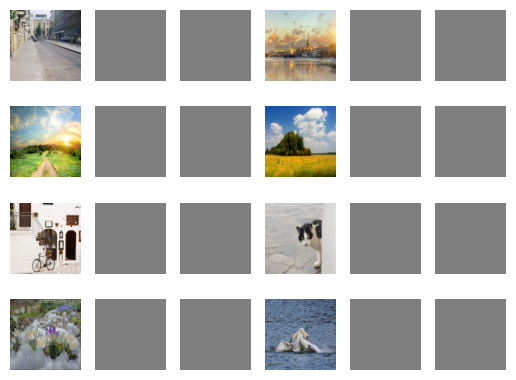

In [38]:
show_samples(samples_ds, torch.zeros_like(samples_ds), torch.zeros_like(samples_ds))

Функции сохранения состояния модели в файлы

In [39]:
import pickle

def pickle_dump(data, filename):
    with open(os.path.join(SAVE_PATH, filename), 'wb') as dump_file:
        pickle.dump(data, dump_file)

def save_model(model, model_filename):
    torch.save(model.state_dict(), os.path.join(SAVE_PATH, model_filename))

In [40]:
def save_all_models(models, counter):
    name_suffix = '_' + str(counter) + '.nn'
    save_model(models["generator_fwd"], GEN_FWD_FNAME_PREFIX + name_suffix)
    save_model(models["generator_bwd"], GEN_BWD_FNAME_PREFIX + name_suffix)
    save_model(models["discriminator_originals"], DISC_ORIG_FNAME_PREFIX + name_suffix)
    save_model(models["discriminator_targets"], DISC_TRGT_FNAME_PREFIX + name_suffix)

In [41]:
def save_state(models, history, counter):
    save_all_models(models, counter)
    pickle_dump(history, HISTORY_FNAME_PREFIX + '_' + str(counter) + '.pkl')

Модели генератора и дискриминатора

In [42]:
class Generator(nn.Module):
    def add_norm_relu(self, layers, features, batch_size, use_batchnorm):
        if batch_size == 1:
            layers += [nn.InstanceNorm2d(features)]
        elif use_batchnorm:
            layers += [nn.BatchNorm2d(features)]
        layers += [nn.ReLU(True)]
    
    def __init__(self, image_size, batch_size, use_batchnorm, encoder_blocks, residual_blocks):
        super().__init__()
        in_layer = [nn.ReflectionPad2d(3),
                 nn.Conv2d(3, GENERATOR_INITIAL_CONV_OUT, kernel_size=7, padding=0, bias=not use_batchnorm)]
        self.add_norm_relu(in_layer, GENERATOR_INITIAL_CONV_OUT, batch_size, use_batchnorm)
        
        self.in_layer = nn.Sequential(*in_layer)

        encoder = []
        
        features = GENERATOR_INITIAL_CONV_OUT
        for i in range(encoder_blocks):
            encoder += [nn.Conv2d(features, features * 2, kernel_size=3, stride=2, padding=1, bias=not use_batchnorm)]
            self.add_norm_relu(encoder, features * 2, batch_size, use_batchnorm)
            features *= 2
            
        self.encoder = nn.Sequential(*encoder)

        self.residual_blocks = nn.ModuleList()
            
        for i in range(residual_blocks):
            residual_block = [nn.ReflectionPad2d(1), nn.Conv2d(features, features, kernel_size=3, padding=0, bias=not use_batchnorm)]
            self.add_norm_relu(residual_block, features, batch_size, use_batchnorm)
            
            residual_block += [nn.ReflectionPad2d(1), nn.Conv2d(features, features, kernel_size=3, padding=0, bias=not use_batchnorm)]
            if batch_size == 1:
                residual_block += [nn.InstanceNorm2d(features)]
            elif use_batchnorm:
                residual_block += [nn.BatchNorm2d(features)]
            
            self.residual_blocks.append(nn.Sequential(*residual_block))

        decoder = []
            
        for i in range(encoder_blocks):
            decoder += [nn.ConvTranspose2d(features, features // 2,
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=not use_batchnorm)]
            self.add_norm_relu(decoder, features // 2, batch_size, use_batchnorm)
            features //= 2
            
        self.decoder = nn.Sequential(*decoder)
        
        assert(features == GENERATOR_INITIAL_CONV_OUT)
        
        self.out_layer = nn.Sequential(nn.ReflectionPad2d(3), nn.Conv2d(features, 3, kernel_size=7, padding=0), nn.Tanh())
        
    def forward(self, x):
        x = self.in_layer(x)
        x = self.encoder(x)

        for res in self.residual_blocks:
            x = x + res(x)

        x = self.decoder(x)
        x = self.out_layer(x)
        return x

In [43]:
class Discriminator(nn.Module):
    def __init__(self, batch_size, use_batchnorm, hidden_layers):
        super().__init__()
        self.in_layer = [nn.Conv2d(3, DISCRIMINATOR_INITIAL_CONV_OUT, kernel_size=4, stride=2, padding=1, bias=not use_batchnorm),
            nn.LeakyReLU(0.2)]
        
        self.hidden_layers = []
        in_features = DISCRIMINATOR_INITIAL_CONV_OUT
        
        for i in range(hidden_layers):
            self.hidden_layers += [nn.Conv2d(in_features, in_features * 2, kernel_size=4, stride=2, padding=1, bias=not use_batchnorm)]
            if batch_size == 1:
                self.hidden_layers += [nn.InstanceNorm2d(in_features * 2)]
            elif use_batchnorm:
                self.hidden_layers += [nn.BatchNorm2d(in_features * 2)]
            self.hidden_layers += [nn.LeakyReLU(0.2, True)]
            in_features *= 2
        
        self.out_layer = [nn.Conv2d(in_features, 1, kernel_size=4, stride=1, padding=0, bias=False), nn.Flatten(), nn.Sigmoid()]
        
        layers = self.in_layer + self.hidden_layers + self.out_layer
                                   
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

Лосс для генератора и словари моделей, лоссов и оптимизаторов.

In [44]:
def generator_loss(model,
                   original, target,
                   target_transformed, original_transformed,
                   original_reconstructed, target_reconstructed,
                   cycle_loss_factor = 10.0, identity_loss_factor = 0.5):
    
    original_preds, target_preds = model["discriminator_originals"](target_transformed), model["discriminator_targets"](original_transformed)
    
    gen_loss_fwd = binary_classifier_criterion(target_preds, torch.ones_like(target_preds, device=device))
    gen_loss_bwd = binary_classifier_criterion(original_preds, torch.ones_like(original_preds, device=device))
    
    cycle_loss = similarity_criterion(original, original_reconstructed) + similarity_criterion(target, target_reconstructed)
    identity_loss = similarity_criterion(target, model["generator_fwd"](target)) + similarity_criterion(original, model["generator_bwd"](original))
    
    return gen_loss_fwd + gen_loss_bwd + cycle_loss_factor * cycle_loss + identity_loss_factor * identity_loss

In [45]:
lr = LR

model = {
    "discriminator_targets": Discriminator(batch_size, use_batchnorm, disc_hidden_layers),
    "discriminator_originals": Discriminator(batch_size, use_batchnorm, disc_hidden_layers),
    "generator_fwd": Generator(image_size, batch_size, use_batchnorm, GENERATOR_ENCODER_BLOCKS, generator_residual_blocks),
    "generator_bwd": Generator(image_size, batch_size, use_batchnorm, GENERATOR_ENCODER_BLOCKS, generator_residual_blocks)
}

criterion = {
    "discriminator": binary_classifier_criterion,
    "generator": generator_loss
}

common_betas = (OPTIMIZER_BETA1, OPTIMIZER_BETA2)

optimizer = {
    "discriminator_targets": torch.optim.Adam(model["discriminator_targets"].parameters(), lr=LR, betas=common_betas, weight_decay=1e-5),
    "discriminator_originals": torch.optim.Adam(model["discriminator_originals"].parameters(), lr=LR, betas=common_betas, weight_decay=1e-5),
    "generator_fwd": torch.optim.Adam(model["generator_fwd"].parameters(), lr=LR, betas=common_betas, weight_decay=1e-5),
    "generator_bwd": torch.optim.Adam(model["generator_bwd"].parameters(), lr=LR, betas=common_betas, weight_decay=1e-5)
}

model["discriminator_targets"] = model["discriminator_targets"].to(device)
model["discriminator_originals"] = model["discriminator_originals"].to(device)
model["generator_fwd"] = model["generator_fwd"].to(device)
model["generator_bwd"] = model["generator_bwd"].to(device)

Буфер для хранения изображений

In [46]:
class Buffer:
    def __init__(self, buffer_size, image_size):
        self.buffer = torch.zeros(buffer_size, 3, image_size, image_size).to(device)
        self.buffer_size = buffer_size
        self.ptr = 0
        
    def add(self, image):
        self.buffer[self.ptr] = image
        
        self.ptr += 1
        self.ptr %= self.buffer_size
        
    def get(self):
        return self.buffer[torch.randint(0, self.buffer_size, (1,))]

In [47]:
class SingularBuffer:
    def __init__(self, buffer_size, image_size):
        self.buffer = torch.zeros(3, image_size, image_size).to(device)
    
    def add(self, image):
        self.buffer = image
        
    def get(self):
        return self.buffer

In [48]:
buffer_targets = Buffer(BUFFER_SIZE, image_size) if IS_BUFFER_USED else SingularBuffer(BUFFER_SIZE, image_size)
buffer_originals = Buffer(BUFFER_SIZE, image_size) if IS_BUFFER_USED else SingularBuffer(BUFFER_SIZE, image_size)

In [49]:
if batch_size != 1 and IS_BUFFER_USED:
    print('Buffer is tailored specifically for 1-sized batches. Change batch size or disable buffer')
    raise ValueError

Код тренировки CycleGAN'а.

In [50]:
def discriminator_step(discriminator, criterion, optimizer, batch_original, batch_transformed):
    optimizer.zero_grad()
    real_preds = discriminator(batch_original)
    real_loss = criterion(real_preds, torch.ones_like(real_preds, device=device))

    fake_preds = discriminator(batch_transformed.detach())
    fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds, device=device))

    loss_disc = real_loss + fake_loss
    loss_disc.backward()
    optimizer.step()
    
    return torch.mean(real_preds).item(), torch.mean(fake_preds).item(), loss_disc.item()

In [51]:
def show_history_plots(history, epochs):
    plt.plot(np.arange(1, epochs + 1), history["losses"]["gen"], label = "gen")
    plt.plot(np.arange(1, epochs + 1), history["losses"]["disc"]["orig"], label = "disc original")
    plt.plot(np.arange(1, epochs + 1), history["losses"]["disc"]["trgt"], label = "disc targets")
    plt.legend(loc = 'upper right')
    plt.title('Losses')
    plt.show()
    
    plt.plot(np.arange(1, epochs + 1), history["scores"]["real"]["orig"], label = "real")
    plt.plot(np.arange(1, epochs + 1), history["scores"]["fake"]["orig"], label = "fake")
    plt.legend(loc = 'upper right')
    plt.title('Original scores')
    plt.show()
    
    plt.plot(np.arange(1, epochs + 1), history["scores"]["real"]["trgt"], label = "real")
    plt.plot(np.arange(1, epochs + 1), history["scores"]["fake"]["trgt"], label = "fake")
    plt.legend(loc = 'upper right')
    plt.title('Target scores')
    plt.show()

In [52]:
def fit(model, criterion, optimizer, epochs, noise_factor = 0.0):
    # Losses & scores
    history = {"losses": {"gen": [], "disc": {"orig": [], "trgt": []}},
               "scores": {"real": {"orig": [], "trgt": []}, "fake": {"orig": [], "trgt": []}}}
    
    save_counter = 0
    
    for epoch in tqdm(range(epochs)):
        disc_orig_loss = []
        disc_trgt_loss = []
        gen_loss = []
        real_orig_score = []
        fake_orig_score = []
        real_trgt_score = []
        fake_trgt_score = []
        
        if epoch > 0:
            print("Epoch %d / %d" % (epoch, epochs))
            transformed_samples = model["generator_fwd"](samples_ds)
            reconstructed_samples = model["generator_bwd"](transformed_samples)
            show_samples(samples_ds, transformed_samples, reconstructed_samples)
            
            show_history_plots(history, epoch)
        
        if IS_BUFFER_USED:
            count = 0
            for originals, targets in zip(originals_dl, targets_dl):
                originals, targets = originals_dl.to_device(originals), targets_dl.to_device(targets)
                
                i = 0
                while i + count < BUFFER_SIZE and i < batch_size:
                    optimizer["generator_fwd"].zero_grad()
                    optimizer["generator_bwd"].zero_grad()

                    originals_transformed, targets_transformed = model["generator_fwd"](originals), model["generator_bwd"](targets)
                    originals_reconstructed, targets_reconstructed = model["generator_bwd"](originals_transformed), model["generator_fwd"](targets_transformed)
                    
                    buffer_targets.add(originals_transformed)
                    buffer_originals.add(targets_transformed)

                    loss_gen = generator_loss(model,
                                              originals, targets,
                                              targets_transformed, originals_transformed,
                                              originals_reconstructed, targets_reconstructed)
                    loss_gen.backward()

                    optimizer["generator_fwd"].step()
                    optimizer["generator_bwd"].step()
                    
                    i += 1
                
                count += i
                if count >= BUFFER_SIZE:
                    break
        
        for originals, targets in zip(originals_dl, targets_dl):
            originals, targets = originals_dl.to_device(originals), targets_dl.to_device(targets)
            
            r_score, f_score, loss_d = discriminator_step(
                model["discriminator_targets"],
                criterion["discriminator"],
                optimizer["discriminator_targets"],
                targets,
                buffer_targets.get()
            )
            
            real_trgt_score.append(r_score)
            fake_trgt_score.append(f_score)
            disc_trgt_loss.append(loss_d)
            
            r_score, f_score, loss_d = discriminator_step(
                model["discriminator_originals"],
                criterion["discriminator"],
                optimizer["discriminator_originals"],
                originals,
                buffer_originals.get()
            )
            
            real_orig_score.append(r_score)
            fake_orig_score.append(f_score)
            disc_orig_loss.append(loss_d)

            optimizer["generator_fwd"].zero_grad()
            optimizer["generator_bwd"].zero_grad()
            
            originals_transformed, targets_transformed = model["generator_fwd"](originals), model["generator_bwd"](targets)
            originals_reconstructed, targets_reconstructed = model["generator_bwd"](originals_transformed), model["generator_fwd"](targets_transformed)
            
            loss_gen = generator_loss(model,
                                      originals, targets,
                                      targets_transformed, originals_transformed,
                                      originals_reconstructed, targets_reconstructed)
            loss_gen.backward()
            
            optimizer["generator_fwd"].step()
            optimizer["generator_bwd"].step()
            gen_loss.append(loss_gen.item())
            
        history["losses"]["gen"].append(np.mean(gen_loss))
        history["losses"]["disc"]["orig"].append(np.mean(disc_orig_loss))
        history["losses"]["disc"]["trgt"].append(np.mean(disc_trgt_loss))
        history["scores"]["real"]["orig"].append(np.mean(real_orig_score))
        history["scores"]["real"]["trgt"].append(np.mean(real_trgt_score))
        history["scores"]["fake"]["orig"].append(np.mean(fake_orig_score))
        history["scores"]["fake"]["trgt"].append(np.mean(fake_trgt_score))
        
        if (epoch + 1) % MODEL_SAVE_PERIOD == 0:
            save_counter += 1
            save_state(model, history, save_counter)
        
        clear_output()
        
    print("Epoch %d / %d" % (epochs, epochs))
    transformed_samples = model["generator_fwd"](samples_ds)
    reconstructed_samples = model["generator_bwd"](transformed_samples)
    show_samples(samples_ds, transformed_samples, reconstructed_samples)
    
    show_history_plots(history, epochs)
    
    save_counter += 1
    save_state(model, history, save_counter)
    
    return history

In [53]:
epochs = EPOCHS

Epoch 100 / 100


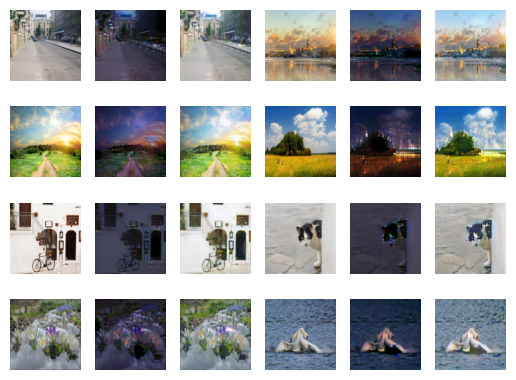

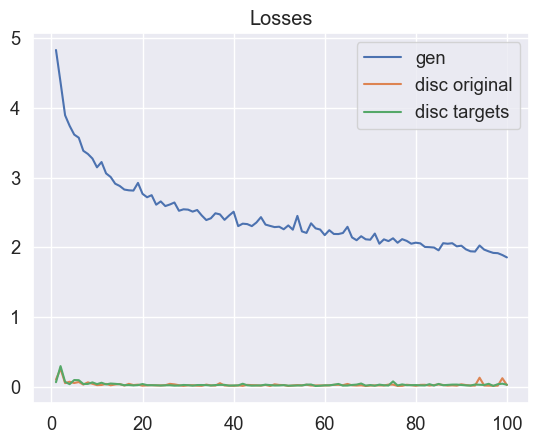

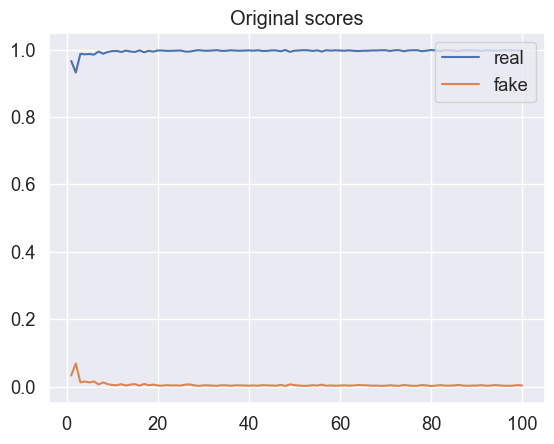

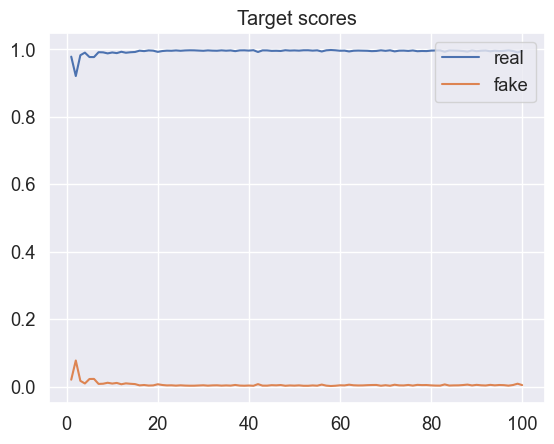

In [52]:
history = fit(model, criterion, optimizer, epochs)

Оценка качества - проверка дискриминатора на тестовом наборе из 800 изображений против 800 сгенерированных из оригинального датасета

In [55]:
model["generator_fwd"].load_state_dict(torch.load('gen_fwd_5.nn'))
model["discriminator_targets"].load_state_dict(torch.load('disc_trgt_5.nn'))

<All keys matched successfully>

In [56]:
model["discriminator_targets"].eval()
model["generator_fwd"].eval()

Generator(
  (in_layer): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
  )
  (encoder): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
  )
  (residual_blocks): ModuleList(
    (0-5): 6 x Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): ReLU(inplace=True)
      (4): Reflection

In [58]:
print(model["discriminator_targets"].training)
print(model["generator_fwd"].training)

False
False


Метрики качества:

In [61]:
import torch.functional as F

X = torch.zeros(1, image_size * image_size * 3)

for batch in test_dl:
    batch = test_dl.to_device(batch)
    X = torch.cat([X, torch.flatten(batch, start_dim = 1).detach().cpu()])

images = X.size(0) - 1

for batch in originals_dl:
    batch = originals_dl.to_device(batch)
    X = torch.cat([X, torch.flatten(model["generator_fwd"](batch), start_dim = 1).detach().cpu()])

y = np.concatenate((np.ones(images), np.zeros(images)))

X = X.numpy()[1:]

In [62]:
print(X.shape)
print(y.shape)

(1600, 49152)
(1600,)


In [63]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

loo = LeaveOneOut()

score = 0.0

for i, (train_idx, test_idx) in enumerate(loo.split(X)):
    knc = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    knc.fit(X[train_idx], y[train_idx])
    ans = knc.predict(X[test_idx])
    if ans == y[test_idx]:
        score += 1.0

print(f"Score: {score / (images * 2)}")

Score: 0.835625


Модель действительно показывает результаты, хотя, вполне возможно, можно и лучше, если бы удалось собрать датасет поприятнее.

### Визуализация распределений

TSNE'шная визуализация распределений - синим из датасета, красным - сгенерированные

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


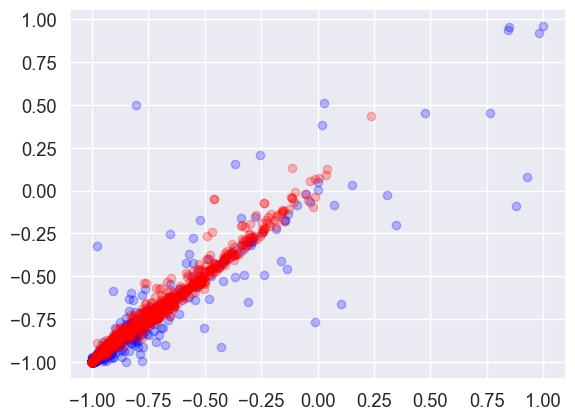

In [64]:
from sklearn.manifold import TSNE

sampled = TSNE(n_components = 2, learning_rate='auto', init='random', n_jobs = -1).fit_transform(X)

real = X[:images].T
fake = X[images:].T

plt.scatter(real[0], real[1], c = (0, 0, 1, 0.25))
plt.scatter(fake[0], fake[1], c = (1, 0, 0, 0.25))
plt.show()

Здесь, вполне возможно, TSNE-визуализация распределений не очень хорошо подходит, так как со сменой оттенков нейросеть справляется вполне неплохо, а такой вариант визуализации как раз и учитывает цвета на изображении, так что сильно плохо было бы вряд ли.<br/>
Оставил TSNE, так как он использовался в последнем домашнем задании по GAN'ам.